# Experiment - RISEI

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

RANDOM_SEED = 250398
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../tmp\logs\20210427-143830
Wall time: 23 ms


## Model

In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': 0.10,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210308-175324', 'cp-0058.ckpt')

loading checkpoint from ../../../tmp\bckp-checkpoints\20210308-175324\cp-0058.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8333333333333334
recall: 0.8064516129032258
f1-score: 0.819672131147541
support: 62


CN
precision: 0.7
recall: 0.7368421052631579
f1-score: 0.717948717948718
support: 38


micro avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


macro avg
precision: 0.7666666666666666
recall: 0.7716468590831917
f1-score: 0.7688104245481295
support: 100


weighted avg
precision: 0.7826666666666666
recall: 0.78
f1-score: 0.7810172341319883
support: 100


samples avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


F1
micro: 0.78
macro: 0.7688104245481295


accuracy_score: 0.78
sensitivity_score: 0.8064516129032258
specificity_score: 0.7368421052631579


Wall time: 32.4 s


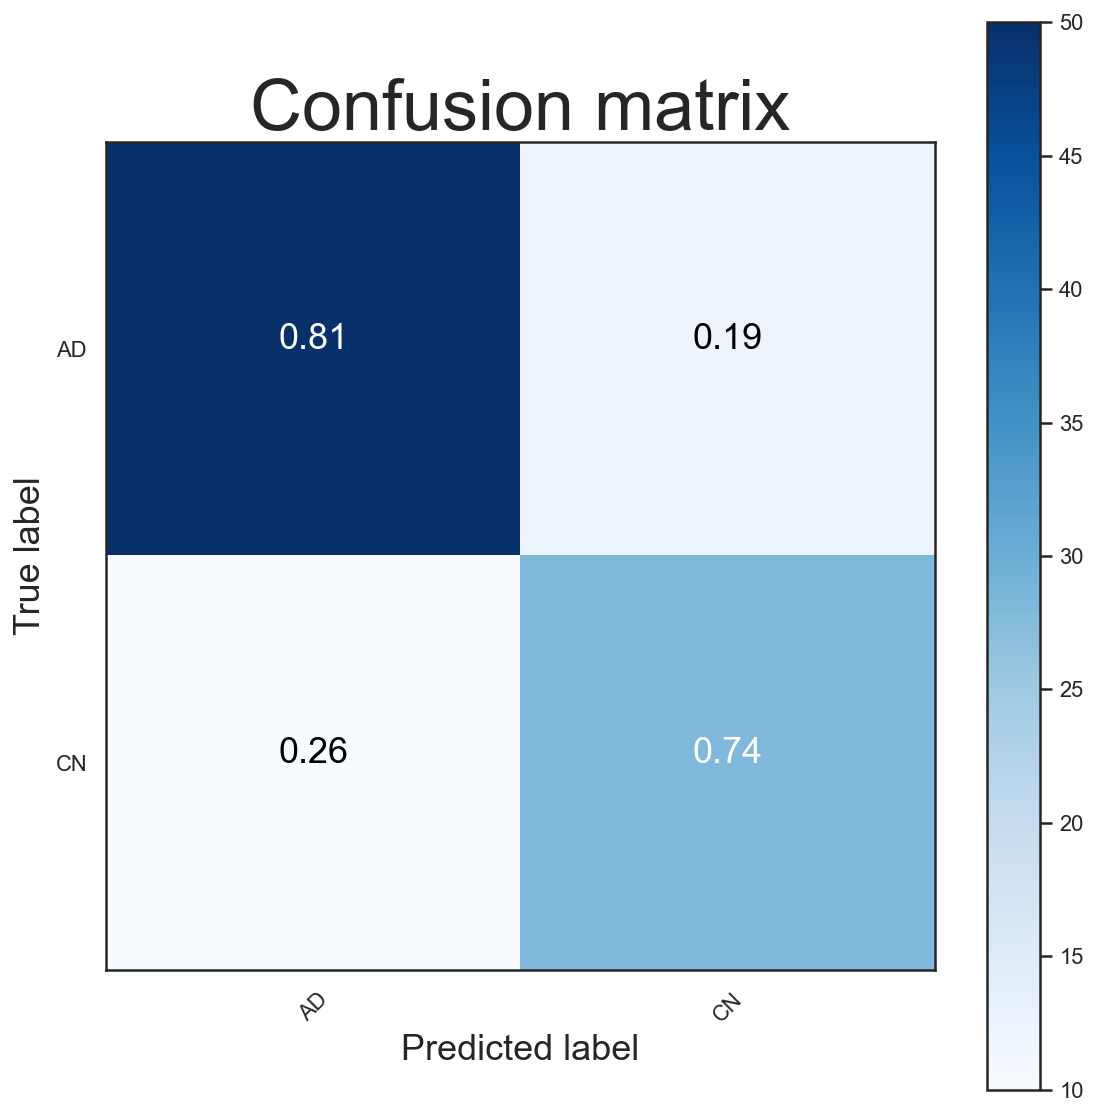

In [8]:
%%time

show_metrics(model, test_seq, class_names)

## Experiments

In [9]:
# DO NOT FORGET TO EDIT!
NOTEBOOK_KEY = 'risei--3d-cnn--m+2048--b1+0--b2+1--s+16--p1+0.25'
# DO NOT FORGET TO EDIT!
BATCH_SIZE = 24
VERBOSE = 1
LOG = True
SEED = 42

heatmap_evaluation_options = {
    'evaluation_step_size': 1000,
    'evaluation_max_steps': -1,
    'evaluation_batch_size': BATCH_SIZE
}

risei_config = {
    's': 16, 
    'p1': 1/3, 
    'b1': 0,
    'b2': 1,
    'b2_value': 1,
    'in_paint': '2d', 
    'in_paint_blending': True, 
    'in_paint_radius': 5,
    'in_paint_2d_to_3d': True,
    'processes': 8, 
}

MASKS_COUNT = 8
RISEI_BATCH_SIZE = 480
MAX_CATEGORY_1 = 10
MAX_CATEGORY_2 = 20
# MAX_CATEGORY_1 = 1
# MAX_CATEGORY_2 = 2

In [10]:
from src.heatmaps.evaluation import HeatmapEvaluationV2
from src.heatmaps.heatmaps import get_heatmap
from src.data import tf_predict, torch_predict
from src.risei import RISEI

risei = RISEI(input_shape[:-1], debug=False, **risei_config)

def heatmap_fn(image_x, image_y, **kwargs): # kwargs - log, seed, evaluation_idx
    seed = kwargs.get('seed', None)
    evaluation_idx = kwargs.get('evaluation_idx', None)
    log = kwargs.get('log', None)
    heatmap_seed = None if seed is None else seed + evaluation_idx
    print(f"generating heatmap (masks_count={MASKS_COUNT}; seed={heatmap_seed})")
    heatmap, _, _ = get_heatmap(
        image_x,
        image_y,
        model,
        risei,
        batch_size=BATCH_SIZE,
        masks_count=MASKS_COUNT,
        risei_batch_size=RISEI_BATCH_SIZE,
        debug=False,
        seed=heatmap_seed,
        log=log
    )
    # print(f'{image_x.shape} {heatmap.shape}')
    return heatmap.reshape(input_shape)

predict_fn = tf_predict(model)

### 10TP 10TN 10FP 10FN

In [11]:
# from src.data import select_from_dataset, numpy_to_sequence

# images_x, images_y, images_y_pred = select_from_dataset(tf_predict(model), test_seq, max_category=MAX_CATEGORY_1)
# print(images_x.shape)
# sequence = numpy_to_sequence(images_x, images_y, batch_size=BATCH_SIZE)

In [12]:
# %%time

# he = HeatmapEvaluationV2(predict_fn, heatmap_fn, sequence, **heatmap_evaluation_options)

# history = he.evaluate('insertion', log=LOG, verbose=VERBOSE, seed=SEED)

# history.save(os.path.join(ROOT_DIR, 'risei-history'), f'{NOTEBOOK_KEY}-insertion-TP-TN-FP-FN')

In [13]:
# %%time

# he = HeatmapEvaluationV2(predict_fn, heatmap_fn, sequence, **heatmap_evaluation_options)

# history = he.evaluate('deletion', log=LOG, verbose=VERBOSE, seed=SEED)

# history.save(os.path.join(ROOT_DIR, 'risei-history'), f'{NOTEBOOK_KEY}-deletion-TP-TN-FP-FN')

### 20TP 20TN

In [14]:
from src.data import select_from_dataset, numpy_to_sequence

images_x, images_y, images_y_pred = select_from_dataset(tf_predict(model), test_seq, max_category=MAX_CATEGORY_2, fp_max=0, fn_max=0)
print(images_x.shape)
sequence = numpy_to_sequence(images_x, images_y, batch_size=BATCH_SIZE)

tp: 20, tn: 20, fp: 0, fn: 0
(40, 104, 128, 104, 1)


In [15]:
%%time

he = HeatmapEvaluationV2(predict_fn, heatmap_fn, sequence, **heatmap_evaluation_options)

history = he.evaluate('insertion', log=LOG, verbose=VERBOSE, seed=SEED)

history.save(os.path.join(ROOT_DIR, 'risei-history'), f'{NOTEBOOK_KEY}-insertion-TP-TN')

sequence len: 40, method: insertion
evaluation 1/40
generating heatmap...
generating heatmap (masks_count=8; seed=42)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:53
auc: 867545.5902218819 (0:01:01s)

evaluation 2/40
generating heatmap...
generating heatmap (masks_count=8; seed=43)
...finished in 0:00:11s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:55
auc: 563102.8628796339 (0:01:07s)

evaluation 3/40
generating heatmap...
generating heatmap (masks_count=8; seed=44)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:54
auc: 885367.2287911177 (0:01:02s)

evaluation 4/40
generating heatmap...
generating heatmap (masks_count=8; seed=45)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:55
auc: 910160.2969169617 (0:01:02s)

evaluation 5/40
generati

...finished in 0:00:54
auc: 790465.8019542694 (0:01:05s)

evaluation 36/40
generating heatmap...
generating heatmap (masks_count=8; seed=77)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:54
auc: 827060.331016779 (0:01:02s)

evaluation 37/40
generating heatmap...
generating heatmap (masks_count=8; seed=78)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:54
auc: 714227.5764197111 (0:01:02s)

evaluation 38/40
generating heatmap...
generating heatmap (masks_count=8; seed=79)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:54
auc: 714122.0357716084 (0:01:01s)

evaluation 39/40
generating heatmap...
generating heatmap (masks_count=8; seed=80)
...finished in 0:00:06s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:53
auc: 830730.8487594128 (0:01:00s)


In [16]:
%%time

he = HeatmapEvaluationV2(predict_fn, heatmap_fn, sequence, **heatmap_evaluation_options)

history = he.evaluate('deletion', log=LOG, verbose=VERBOSE, seed=SEED)

history.save(os.path.join(ROOT_DIR, 'risei-history'), f'{NOTEBOOK_KEY}-deletion-TP-TN')

sequence len: 40, method: deletion
evaluation 1/40
generating heatmap...
generating heatmap (masks_count=8; seed=42)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:44
auc: 898406.392544508 (0:00:51s)

evaluation 2/40
generating heatmap...
generating heatmap (masks_count=8; seed=43)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:46
auc: 723153.9119631052 (0:00:53s)

evaluation 3/40
generating heatmap...
generating heatmap (masks_count=8; seed=44)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:43
auc: 818642.9640650749 (0:00:51s)

evaluation 4/40
generating heatmap...
generating heatmap (masks_count=8; seed=45)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:45
auc: 918906.4688533545 (0:00:52s)

evaluation 5/40
generating

...finished in 0:00:45
auc: 756971.6933369637 (0:00:53s)

evaluation 36/40
generating heatmap...
generating heatmap (masks_count=8; seed=77)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:44
auc: 897030.812561512 (0:00:51s)

evaluation 37/40
generating heatmap...
generating heatmap (masks_count=8; seed=78)
...finished in 0:00:06s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:42
auc: 778133.3169937134 (0:00:49s)

evaluation 38/40
generating heatmap...
generating heatmap (masks_count=8; seed=79)
...finished in 0:00:07s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:47
auc: 787551.969319582 (0:00:54s)

evaluation 39/40
generating heatmap...
generating heatmap (masks_count=8; seed=80)
...finished in 0:00:08s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:45
auc: 775171.7191338539 (0:00:54s)

